**BOOK: GENERATIVE DEEP LEARNING O'REILLY**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (layers, models, datasets, callbacks,
                        losses, optimizers, metrics)

from scipy.stats import norm

## Variables

In [2]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 3
BETA = 500

## Getting the Data

In [3]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
# Preprocess the data
def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [5]:
# display(x_train)

## Creating a Sampling Layer

In [6]:
# Sample from the distribution defined by z_mean and z_log_var
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Encoder

In [7]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input"
)

x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)

x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this
print(shape_before_flattening)

x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

(4, 4, 128)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_1[0][0]']            
                                                                                

## Decoder

In [8]:
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        18464 

## Training the VAE

In [9]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    ## This function describes what we would like returned when we call
    ## VAE on a particular input image
    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [10]:
vae = VAE(encoder, decoder)
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [11]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [12]:
vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback]
)

Epoch 1/3
600/600 [==============================] - ETA: 0s - total_loss: 161.1192 - reconstruction_loss: 156.7669 - kl_loss: 4.3522

600/600 [==============================] - 207s 338ms/step - total_loss: 161.1192 - reconstruction_loss: 156.7669 - kl_loss: 4.3522 - val_loss: 142.0987 - val_reconstruction_loss: 137.2368 - val_kl_loss: 4.8618
Epoch 2/3
600/600 [==============================] - ETA: 0s - total_loss: 135.8970 - reconstruction_loss: 131.0280 - kl_loss: 4.8691

600/600 [==============================] - 190s 317ms/step - total_loss: 135.8970 - reconstruction_loss: 131.0280 - kl_loss: 4.8691 - val_loss: 137.2930 - val_reconstruction_loss: 132.3330 - val_kl_loss: 4.9600
Epoch 3/3
600/600 [==============================] - ETA: 0s - total_loss: 133.8678 - reconstruction_loss: 128.9376 - kl_loss: 4.9303

600/600 [==============================] - 190s 317ms/step - total_loss: 133.8678 - reconstruction_loss: 128.9376 - kl_loss: 4.9303 - val_loss: 136.5022 - val_reconstruction_loss: 131.4037 - val_kl_loss: 5.0986


## Reconstruct using the VAE

In [13]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [14]:
# Create predictions
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print('Example real clothing items')
display(example_images)

print('Reconstructions')
display(reconstructions)

157/157 [==============================] - 6s 35ms/step
Example real clothing items


array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.        ],
         [0.        ],
         [0.  

Reconstructions


array([[[[2.73222281e-06],
         [1.97446582e-07],
         [7.21004312e-07],
         ...,
         [1.14758250e-05],
         [6.20618630e-06],
         [3.90525151e-04]],

        [[2.86309838e-08],
         [1.03349562e-09],
         [3.22438964e-08],
         ...,
         [1.80648487e-06],
         [6.09086499e-07],
         [2.98218492e-05]],

        [[6.62025590e-09],
         [3.50217522e-10],
         [3.14220223e-08],
         ...,
         [1.95482808e-05],
         [4.79169785e-06],
         [7.86062228e-05]],

        ...,

        [[5.93287382e-07],
         [9.31396738e-09],
         [3.79144147e-08],
         ...,
         [1.79047220e-06],
         [3.24577684e-07],
         [8.01569422e-06]],

        [[2.13301576e-07],
         [3.18796567e-09],
         [3.94718347e-09],
         ...,
         [1.83574357e-07],
         [5.32688880e-08],
         [3.91283174e-06]],

        [[7.03992555e-05],
         [1.24455164e-06],
         [1.26297664e-06],
         ...,
 

## Embed using the Encoder

In [15]:
# Encode example images
z_mean, z_var, z = encoder.predict(example_images)

# Print examples of the embeddings
print(z[:10])

157/157 [==============================] - 2s 12ms/step
[[ 1.278089   -0.20537178]
 [-0.28553954  0.9987157 ]
 [-2.7739134  -0.29124773]
 [-2.2308662  -1.2515234 ]
 [-0.06728216 -0.07359135]
 [-1.7692554  -0.39886075]
 [-0.14995624 -1.428462  ]
 [-0.0850497  -0.5245004 ]
 [ 2.197903   -1.4948472 ]
 [ 2.2689629  -0.34420237]]


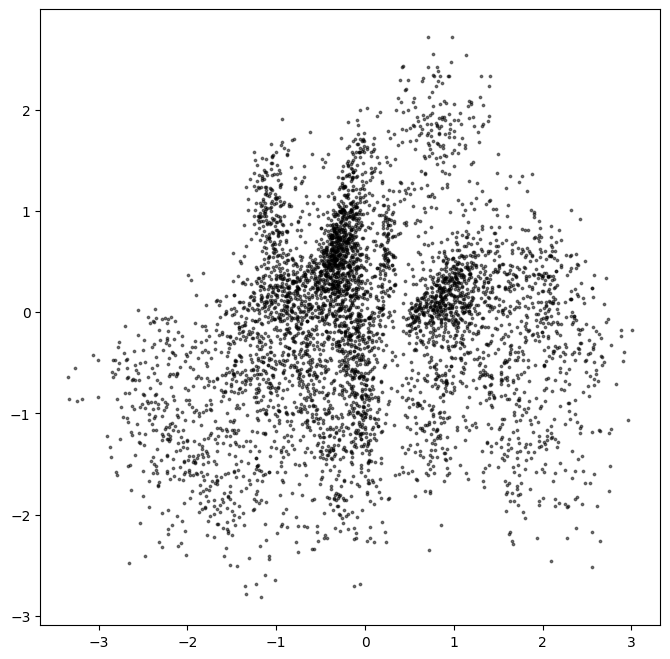

In [16]:
# Show the encoder points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c='black', alpha=0.5, s=3)
plt.show()

## Generate using the Decoder

In [17]:
# Sample points
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_height * grid_width, 2))

# Decode the sampled points
reconstructions = decoder.predict(z_sample)

# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

1/1 [==============================] - 0s 199ms/step


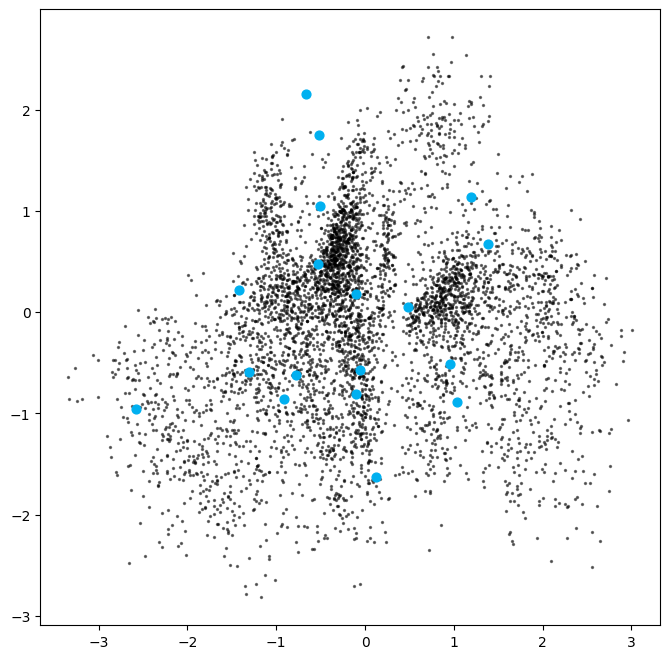

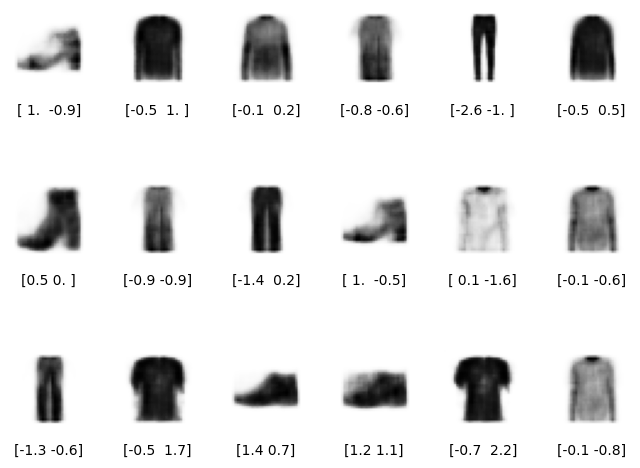

In [19]:
# Plotting
figsize = 8
plt.figure(figsize=(figsize, figsize))

# Original Embeddings
plt.scatter(z[:, 0], z[:, 1], c='black', alpha=0.5, s=2)

# Newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c='#00B0F0', alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")